<a href="https://colab.research.google.com/github/skl30misha/data-science-portfolio/blob/main/SmartCVScanner/SmartCVScanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Description:

This project uses BERT, a powerful Natural Language Processing (NLP) model, to automatically analyze and filter resumes for Data Scientist roles. It performs skill matching by checking resumes against a list of key Data Science skills. Suitable resumes (with skill match above a threshold) are automatically uploaded to Google Drive for easy access by HR teams. This speeds up the recruitment process by quickly identifying the best candidates based on their skills.

In [10]:
pip install transformers

In [11]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/SmartCVScanner')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  PDF Upload and Text Extraction

In [12]:
!pip install PyMuPDF

In [13]:
from google.colab import files
import fitz  # PyMuPDF

def extract_text_from_pdf(file_path):
    text = ""
    with fitz.open(file_path) as doc:
        for page in doc:
            text += page.get_text()
    return text

# 1. Upload file using the button
uploaded = files.upload()


Saving Mykhailo_Sakivskyi_Data_Science_CV.pdf to Mykhailo_Sakivskyi_Data_Science_CV (3).pdf


#Extract and clean the text of the downloaded file

In [14]:
from bs4 import BeautifulSoup
import re

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Convert to lowercase (can be skipped if using a cased model)
    text = text.lower()

    # Remove unwanted characters, keeping emails, links, etc.
    text = re.sub(r"[^\w\s@.:/]", "", text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text.strip()


# Apply to uploaded file(s)
for filename in uploaded.keys():
    print(f"✅ File uploaded: {filename}")

    # Step 1: extract text
    raw_text = extract_text_from_pdf(filename)

    # Step 2: clean text
    cleaned_text = clean_text(raw_text)

    # Step 3: preview the result
    print("\n📄 First 1000 characters of cleaned text:\n")
    print(cleaned_text[:1000])



✅ File uploaded: Mykhailo_Sakivskyi_Data_Science_CV (3).pdf

📄 First 1000 characters of cleaned text:

education projects fife college edinburgh diploma in data science scqf level 7 2025present sakivskyi mykhailo experience profile data scientist data analyst python power bi machine learning sandi data analyst assistant prepared and transformed raw datasets using python pandas numpy to support predictive modeling. conducted data cleaning missing value handling and data formatting for machine learning workflows. created interactive dashboards in power bi and visual reports with matplotlib/seaborn to support decisionmaking. performed customer segmentation campaign performance evaluation and trend analysis for marketing insights. collaborated with senior data scientists on eda feature engineering and model evaluation tasks. bydgoszcz poland solair installation junior data analyst marketing manager collected organized and structured customer and sales data to support digital marketing stra

# EDA

📏 Length of cleaned text: 4937 characters
🔢 Number of words: 678

📊 Top 20 most frequent words:
and: 41
data: 25
in: 16
to: 15
i: 14
with: 9
customer: 8
marketing: 8
for: 7
my: 7
power: 6
learning: 6
analyst: 5
bi: 5
business: 5
a: 5
edinburgh: 4
science: 4
sakivskyi: 4
mykhailo: 4


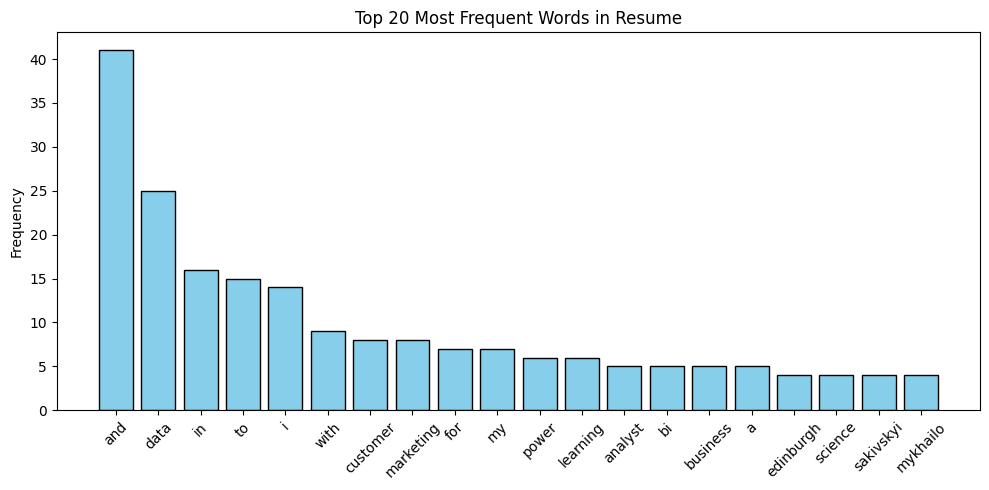


🧠 Vocabulary richness: 0.534

🧬 Number of BERT tokens: 906

🔍 First 30 tokens:
['education', 'projects', 'fife', 'college', 'edinburgh', 'diploma', 'in', 'data', 'science', 'sc', '##q', '##f', 'level', '7', '202', '##5', '##pres', '##ent', 'sa', '##ki', '##vsky', '##i', 'my', '##kha', '##ilo', 'experience', 'profile', 'data', 'scientist', 'data']

⚠️ WARNING: Token count exceeds 512 — text needs to be chunked.


In [15]:
# 📦 Import libraries
import matplotlib.pyplot as plt
from collections import Counter
from transformers import BertTokenizer

# 🧼 Using cleaned text
text = cleaned_text

# 1️⃣ Number of characters and words
print(f"📏 Length of cleaned text: {len(text)} characters")
print(f"🔢 Number of words: {len(text.split())}")

# 2️⃣ Word frequency analysis
word_counts = Counter(text.split())
most_common = word_counts.most_common(20)
print("\n📊 Top 20 most frequent words:")
for word, count in most_common:
    print(f"{word}: {count}")

# 3️⃣ Visualization (Top 20 words)
words, counts = zip(*most_common)
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue', edgecolor='black')
plt.title("Top 20 Most Frequent Words in Resume")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 4️⃣ Vocabulary richness
vocab_richness = len(set(text.split())) / len(text.split())
print(f"\n🧠 Vocabulary richness: {vocab_richness:.3f}")

# 5️⃣ Tokens for BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokens = tokenizer.tokenize(text)
print(f"\n🧬 Number of BERT tokens: {len(tokens)}")

# 6️⃣ Show first 30 tokens
print("\n🔍 First 30 tokens:")
print(tokens[:30])

# 7️⃣ Check for token limit exceedance
if len(tokens) > 512:
    print("\n⚠️ WARNING: Token count exceeds 512 — text needs to be chunked.")
else:
    print("\n✅ Text fits into a single BERT run (up to 512 tokens)")






# Zero-Shot Classification от Hugging Face

In [16]:
from transformers import pipeline
import re

# Model initialization
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
labels = ["Data Scientist", "Not suitable"]

# Skills list for Data Scientist
data_science_skills = [
    "python", "sql", "pandas", "numpy", "matplotlib", "seaborn", "scikit-learn",
    "machine learning", "deep learning", "tensorflow", "keras", "xgboost",
    "data visualization", "eda", "statistics", "regression", "classification", "power bi"
]

# Function to evaluate skills in the text
def evaluate_skills(text, skill_list):
    text_lower = text.lower()
    found_skills = []
    for skill in skill_list:
        pattern = r'\b' + re.escape(skill.lower()) + r'\b'
        if re.search(pattern, text_lower):
            found_skills.append(skill)
    score = len(found_skills) / len(skill_list)
    return score, found_skills

# Run zero-shot classification
result = classifier(cleaned_text, candidate_labels=labels)
predicted = result["labels"][0]
print(f"\n🏷️ Predicted profession: {predicted}")

# Threshold for skill match acceptance
threshold = 0.7

if predicted == "Data Scientist":
    score, matched = evaluate_skills(cleaned_text, data_science_skills)
    percent = score * 100
    print(f"🧠 Skill match: {len(matched)}/{len(data_science_skills)} = {percent:.1f}%")
    print("✅ Found skills:", ", ".join(matched))

    if score >= threshold:
        print("📨 Resume is suitable — send to HR ✅")
    else:
        print("❌ Not enough skills — reject")
else:
    print("❌ This is not a Data Scientist resume — reject")



Device set to use cpu



🏷️ Predicted profession: Data Scientist
🧠 Skill match: 15/18 = 83.3%
✅ Found skills: python, sql, pandas, numpy, matplotlib, seaborn, machine learning, deep learning, keras, xgboost, eda, statistics, regression, classification, power bi
📨 Resume is suitable — send to HR ✅
